Tarin Eccleston: COMPSCI 762 Assignment 2

Model Selection

To predict the venue type given the Yelp data, including features such as venue name, coordinates, mean check-in time (hour) and review. I chose the one that provided the best prediction accuracy using partitioned and actual test data for submission. My preferred model uses Compliment Naive Bayes with the review, mean check-in time and venue name features included. I used appropriate preprocessing and modelling techniques given to increase the accuracy score. The evaluation procedure will be discussed at the end of this report. 

For Task 1, I tried different models to predict venue type using just the review feature. Model 1 is a blank model, which used CountVectorizer() on the review data to put the segment and one-hot encode each word for each instance. I then used multinomialNB(), the standard Naive Bayes implementation in sklearn. The chosen model performed below baseline at 87.15% accuracy.

The exploratory data analysis (EDA) for the most common words in the review feature showed a reasonable distribution, . For Model 2, I added stop words and strip accents as preprocessing techniques. This removed common English words that are not typically useful for classification, such as ‘is’ or ‘I’. Strip accents are used to remove accents from characters in the text, which can be essential for maintaining consistency across different languages or text sources. The resulting model didn’t perform any better than Model 2, with the same accuracy of 87.15%. However, I decided to include these preprocessing parameters in the final model for good practice. 

The EDA showed an imbalanced class label where "Restaurants" appears to be the majority class label, taking up to 62% of the class, followed by "Shopping" at 26%, then "Nightlife" at 11%. This is not ideal when model building as we will see inherent bias towards classifying a venue as a "Restaurant" compared to "Shopping" or "Nightlife". This is because the prior probabilities of restaurant P(yres) will be higher than that of P(ynight) and P(yshop) purely due to class label distribution. I solve this by performing oversampling and undersampling of the minority and majority classes for Model 3. Model 3 performed worst in most cases; in this particular simulation, is scored below Models 1 and 2 with an accuracy of 86.8%. This could be explained by the loss of information when undersampling the majority class and the bias caused by introducing more bootstrapped samples from the minority classes.

I used ComplimentNB() (CNB) for Model 4, using the same preprocessing techniques in Model 2, and found it had similar accuracy to the other models. CNB is a variant of the Naive Bayes algorithm but for dealing with imbalanced data. CNB estimates the likelihood of each feature for the non-target class and then derives the possibility for the target class by subtracting the non-target probability from 1. I chose the model in the end as it is robust to imbalanced class labels and doesn’t require us to over/undersample, which could lead to information loss or bias. The Kaggle accuracy score, when predicted on the test data, was 90.1% - an improvement from the baseline.

For Task 2, I wanted to add more variables to the model. I did another EDA on the remaining variables and decided not to include the venue coordinates, as the coordinate distributions between each class are not distinguishable from the violin plots. The mean check-in time in hours differed between class labels, so I included that in Model 5. 

The primary preprocessing technique I used in Model 5 was binning mean check-in time into 30-minute intervals and one-hot-encoding to make the feature inputs compatible with Naive Bayes. I found the accuracy increased significantly to 88.2%. The EDA on word frequency in venue name showed that each class label “Restaurant”, “Shopping” and “Nightlife” had different common words in their respective venue names. I included this as a third feature in the model and used countVectoriser() as per Model 2. The resulting accuracy increased to 89.4%. I chose this as my final model. The Kaggle accuracy score, when predicted on the test data, was 92.2%.

Evaluation Procedure

I used GridSearchCV to find the optimal combination of hyperparameters by testing the grid space. I mainly compared using prior probabilities or not for all models in the Nave Bayes equation and different Laplace smoothing alpha values. Firstly I split the training data into a further training and testing set. I found that the better-performing models used prior probabilities. Laplace smoothing is a technique used in probability theory and machine learning to avoid zero possibilities in cases with limited data. It involves adding a small constant to the counts of features or categories, thereby improving the accuracy and robustness of the model. I found that this dataset's most common alpha values were between 0.5 and 1.0, with the best models requiring an alpha of 0.75.

I use stratified cross-validation to partition the training set into ten portions. Stratified cross-validation splits data in a way that maintains the proportion of instances of each class in each fold. This is especially important when our dataset is imbalanced. 

I used a pipeline to preprocess the training and validation folds independently. This avoids information leakage between datasets when training and validating the model. 

After using the training set, I extract the best model from GridSearch and use the best accuracy score and standard deviation across 10 folds. I used the unpreprocessed testing set to test the accuracy of the best model and used that to drive my decision-making process.

Other Comments

I tried other preprocessing techniques, such as stemming and lemmatisation; however, they didn’t significantly improve model performance and were a little overkill, so I excluded them from the final model.



Task 1: Using Review data to Model Venue Category

In [1]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from scipy import sparse

import pandas as pd
import numpy as np

import seaborn as sns
import folium
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [2]:
k_folds = 5
rs = 951

In [3]:
yelp_df = pd.read_csv('../data/input/train.csv')
yelp_test_df = pd.read_csv('../data/input/test.csv')

X = yelp_df["review"]
y = yelp_df["category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

Exploratory Data Analysis on Review Data

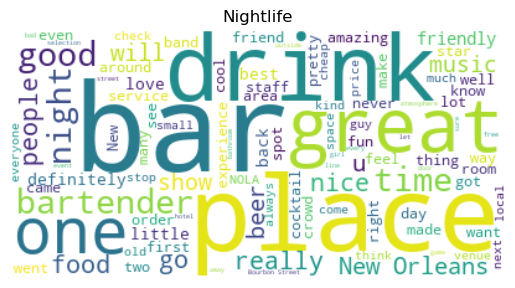

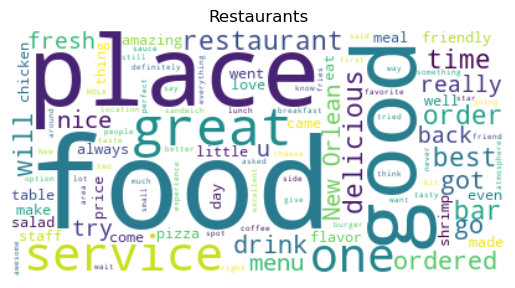

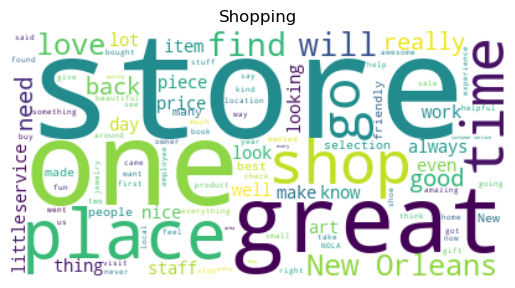

In [4]:
# Subset the data to only include venue name and category columns
df = yelp_df[['review', 'category']]

# Group the venue names by their associated category
grouped = df.groupby('category')

# Create a WordCloud for each category
for category, group in grouped:
    # Concatenate all venue names for this category into one string
    text = ' '.join(group['review'].tolist())
    # Create a WordCloud object with desired parameters
    wc = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue')
    # Generate the WordCloud image
    wc.generate(text)
    # Create a matplotlib plot of the WordCloud
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
    plt.show()

Distribution of common words in each class label seems reasonable. No need to preprocess any unusual words. We can deal with stop words later.

Model 1: Implement Multinomial Naive Bayes with Unpreprocessed Data

In [5]:
params = {
    'clf__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'clf__fit_prior': [True, False]
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (CountVectorizer(), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', transformer),
    ('clf', MultinomialNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=rs)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'clf__alpha': 0.5, 'clf__fit_prior': False}
Test accuracy: 87.1479  %
Standard deviation: 0.7566  %


Poor performance. Below baseline.

Model 2: Implement Multinomial Naive Bayes with Preprocessing (Stop Words, and Strip Accents)

In [6]:
params = {
    'clf__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'clf__fit_prior': [True, False]
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (CountVectorizer(stop_words='english', strip_accents= 'ascii'), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', transformer),
    ('clf', MultinomialNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=rs)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'clf__alpha': 0.5, 'clf__fit_prior': False}
Test accuracy: 87.1479  %
Standard deviation: 1.146  %


Slightly better performance using stop words and split accents. Could be useful when implemented on large dataset sets.

Let's evaluate how balanced our class labels are...

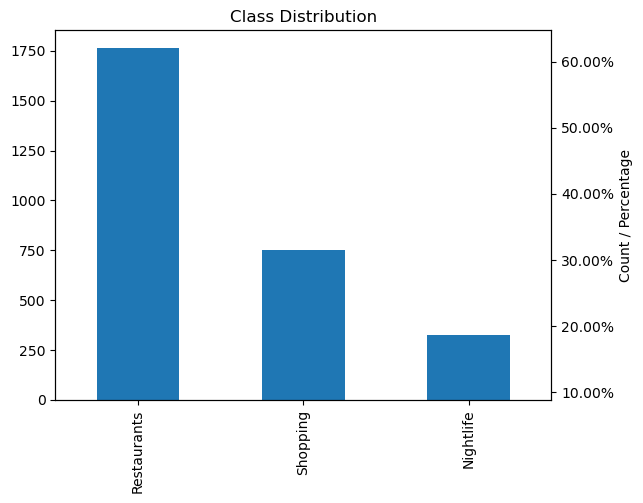

In [7]:
class_counts = y.value_counts()
# calculate the percentage of each class
class_percentages = (class_counts / class_counts.sum()) * 100

# create a bar plot of the categorical class distribution with percentages
fig, ax = plt.subplots()
class_counts.plot(kind='bar', ax=ax)
ax2 = ax.twinx()
class_percentages.plot(kind='line', color='red', ax=ax2, linestyle="None",marker='None')
ax2.yaxis.set_major_formatter('{x:.2f}%')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count / Percentage')
plt.show()

"Restaurants" appears to be the majority class label, taking up to 62% of the class, followed by "Shopping" at 26% then "Nightlife" at 11%. This is not ideal when model building as we will see inherent bias towards classifiying a venue as a "Restaurant" compared to "Shopping" or "Nightlife". This is because the prior probabilities of restaruant P(yres) will be higher than that of P(ynight) and P(yshop) purely due to class label distribution. I solve this by performing oversampling of our minority class labels.

Model 3: Implement Naive Bayes with Preprocessing and Over and Undersampling Class Labels

In [8]:
params = {
    # reduce alpha values for fast processing of gridsearchCV
    'clf__alpha': [0.5, 0.75, 1, 1.25, 1.5],
    'clf__fit_prior': [True, False],
    'over_sampler__sampling_strategy': ['not minority', 'not majority', 'minority', 'all'],
    'under_sampler__sampling_strategy': ['majority', 'not minority', 'not majority', 'all'],
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (CountVectorizer(stop_words='english', strip_accents= 'ascii'), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('vect', transformer),
    ('over_sampler', RandomOverSampler()),
    ('under_sampler', RandomUnderSampler()),
    ('clf', MultinomialNB(alpha=0.5, fit_prior=True))
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=rs)

# search hyperparameter space
grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'clf__alpha': 1, 'clf__fit_prior': False, 'over_sampler__sampling_strategy': 'all', 'under_sampler__sampling_strategy': 'majority'}
Test accuracy: 86.7958  %
Standard deviation: 0.9164  %


Doesn't perform much better than other models. Try Compliment Naive Bayes as it is better with dealing with imbalanced classes without having to bootstrap samples or reduce samples.

Model 4: Compliment Naive Bayes with Preprocessing

In [22]:
params = {
    'cnb__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'cnb__fit_prior': [True, False]
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (CountVectorizer(stop_words='english', strip_accents= 'ascii'), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('trans', transformer),
    ('cnb', ComplementNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=7)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'cnb__alpha': 1, 'cnb__fit_prior': True}
Test accuracy: 86.7958  %
Standard deviation: 0.8583  %


In [10]:
final_model_task_1 = best_model
final_prediction_task_1 = final_model_task_1.predict(yelp_test_df["review"])
final_submission_task_1 = pd.DataFrame({'ID': yelp_test_df["ID"], 'category': final_prediction_task_1})

final_submission_task_1.to_csv('../data/output/submission_1.csv', index=False)

Task 2: Using Other Variables to Model Venue Category

Exploratory Data Analysis

In Task 2, we will like to add other variables into our Naive Bayes model (model 4). We will like to find the most useful variables, we can do this by exploratory data analysis. If numerical variables, latitude, longitude and mean check-in time have different distributions between the three class labels, then these variables are probably useful in our model. We use the whole training dataset to inspect this. We would also like to explore the frequencies of words in venue names, and decide whether that can be used in our model.

Coordinate Data

<AxesSubplot:xlabel='category', ylabel='latitude'>

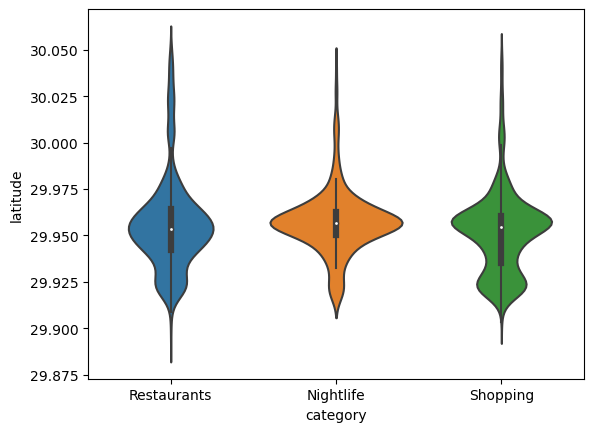

In [11]:
# looking at the whole training dataset
# latitude 
sns.violinplot(x='category', y='latitude', data=yelp_df)

<AxesSubplot:xlabel='category', ylabel='longitude'>

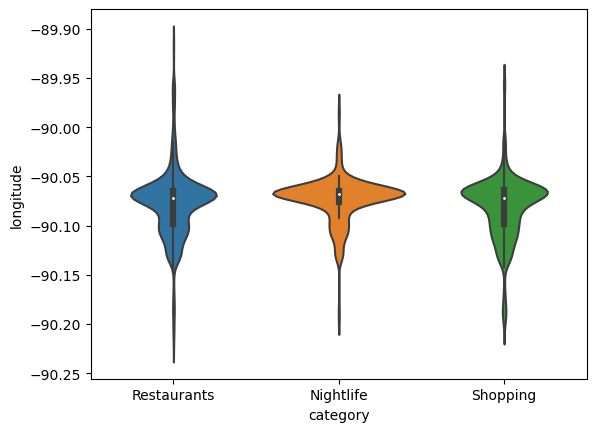

In [12]:
# looking at the whole training dataset
# longitude 
sns.violinplot(x='category', y='longitude', data=yelp_df)

In [13]:
# Create a map centered on the first review's coordinates
map = folium.Map(location=[yelp_df['latitude'][0], yelp_df['longitude'][0]], zoom_start=12)

# Loop through the reviews and add a marker for each one
for index, row in yelp_df.iterrows():
    # Add a marker for this review's location
    marker = folium.Marker(location=[row['latitude'], row['longitude']])
    marker.add_to(map)
map

It appears that there latitude and longitude have very similar distributions between the three class labels, therefore adding these variables into our model shouldn't make the model more accuracy. As shown on the map, we only get data for venues in New Orleans. Furthermore using geographic information to seperate between class labels is quite tricky as there are many other geographic information such as suburb, population, which might have a direct effect on the venue type. Using just the raw coordinates might introduce more noise, or possible overfitting to these particular locations. An idea would be to use the coordinates to get information such as suburb and demographic information using an API and using those variables in our model. However this is outside of the scope of this investigation.

Mean Check-in Time Data

<AxesSubplot:xlabel='category', ylabel='mean_checkin_time'>

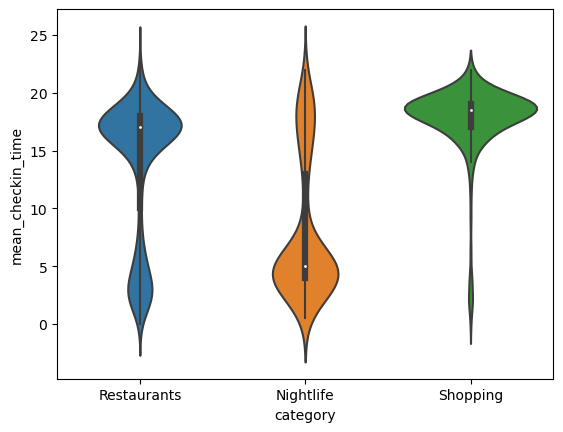

In [14]:
# looking at the whole training dataset
# mean checkin time 
sns.violinplot(x='category', y='mean_checkin_time', data=yelp_df, ylim=(0, 24))

For mean check-in time, each class label appears to have different distributions, therefore could be a useful variable to include into our model. Restaurants appears to be multimodal with centers at around the early morning and dinner time. Shopping appears to be mono modal with a center around 7pm. Whereas nightlight appears to be slightly multi-modal with the main center around 4am and the minor center around 7pm. This appears reasonable to what we would expect in reality. Since we are using Naive Bayes, one approach might be to bin each hour/half-hour/fifteen minutes and one-hot encode the bin for each instance.

Venue Name Data

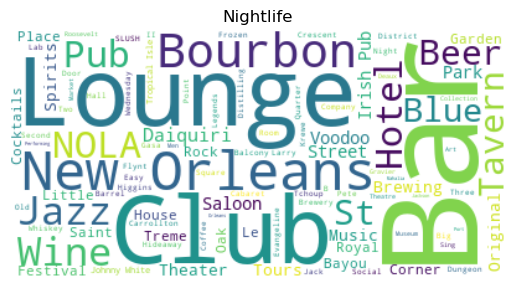

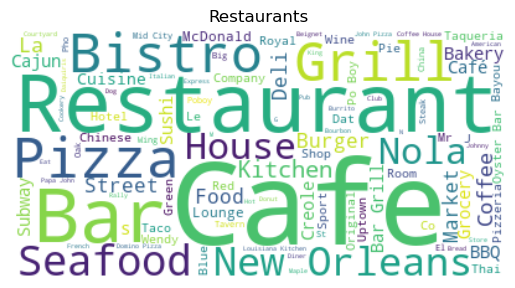

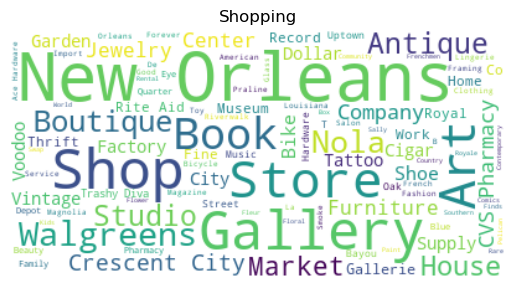

In [15]:
# Subset the data to only include venue name and category columns
df = yelp_df[['name', 'category']]

# Group the venue names by their associated category
grouped = df.groupby('category')

# Create a WordCloud for each category
for category, group in grouped:
    # Concatenate all venue names for this category into one string
    text = ' '.join(group['name'].tolist())
    # Create a WordCloud object with desired parameters
    wc = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='steelblue')
    # Generate the WordCloud image
    wc.generate(text)
    # Create a matplotlib plot of the WordCloud
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(category)
    plt.show()

It appears that there is some distinction between "Shopping", "Restaurant" and "Nightlife" venue names, so we can include it in our model. I would like to remove "Orleans" as this is geographic information which doesn't directly relate to venue type.

Model 5: Compliment Naive Bayes with Mean Check-In Time

In [16]:
# recollect X data to contain mean check-in time
X = yelp_df[['mean_checkin_time', 'review']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

In [17]:
# binning and one-hot encoding function for mean check-in time
class BinMeanCheckInTime(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        bins = np.arange(0, 24, 0.5)
        binned = np.digitize(X, bins) - 1
        encoded = sparse.csr_matrix(np.eye(len(bins))[binned])
        return encoded

I chose a bin width of 30 minutes as there was no difference in model performance between using smaller bins. Larger bin size result in less features after one-hot encoding, therefore faster computing.

In [18]:
params = {
    'cnb__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'cnb__fit_prior': [True, False]
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (BinMeanCheckInTime(), 'mean_checkin_time'),
    (CountVectorizer(stop_words='english', strip_accents= 'ascii'), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('trans', transformer),
    ('cnb', ComplementNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=7)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'cnb__alpha': 0.75, 'cnb__fit_prior': True}
Test accuracy: 88.2042  %
Standard deviation: 0.4894  %


Model 5 is much more accurate after we use the mean checkin time. Keep that in our model

Model 6: Compliment Naive Bayes with Mean Check-In Time and Venue Name

In [19]:
# recollect X data to contain mean check-in time and venue name
X = yelp_df[['name', 'mean_checkin_time', 'review']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rs)

In [20]:
custom_stop_words = set(CountVectorizer(stop_words='english').get_stop_words())
custom_stop_words.add("Orleans")

params = {
    'cnb__alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2],
    'cnb__fit_prior': [True, False]
}

# transforms each feature independantly according to specified rules
transformer = make_column_transformer(
    (BinMeanCheckInTime(), 'mean_checkin_time'),
    (CountVectorizer(stop_words=custom_stop_words, strip_accents= 'ascii'), 'name'),
    (CountVectorizer(stop_words='english', strip_accents= 'ascii'), 'review')
)

# where our k-folds will be independantly piped into (1 fold count vectorised independantly of the other 9 folds) this ensures no information leakage between the training and validation sets
pipeline = Pipeline([
    ('trans', transformer),
    ('cnb', ComplementNB())
])

# data is split in a way that maintains the proportion of instances of each class in each fold. used when testing with imbalanced data
cv_struct = RepeatedStratifiedKFold(n_splits = k_folds, n_repeats=1, random_state=7)

grid_search = GridSearchCV(pipeline, params, cv=cv_struct, scoring='accuracy')
grid_search.fit(X_train, y_train)

# gather best hyperparameters, best model use standard deviation for an estimate on how 
print("Best hyperparameters: ", grid_search.best_params_)
best_params = grid_search.best_params_
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
best_model = grid_search.best_estimator_

# predictions
test_predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
mean_accuracy = test_accuracy.mean()

# crude estimation of percentage standard deviation based on test accuracy and standard deviation from cross-validation
percent_std_dev = std_dev / mean_accuracy * 100

print('Test accuracy:', round(test_accuracy * 100, 4), " %")
print('Standard deviation:', round(percent_std_dev, 4), " %")

Best hyperparameters:  {'cnb__alpha': 0.75, 'cnb__fit_prior': True}
Test accuracy: 89.4366  %
Standard deviation: 0.747  %


Including the venue name appears to increase accuracy. Did some preprocessing to include "Orleans" to the stop words. Didn't improve the accuracy.

Model 6 using Compliment Naive Bayes with Mean Check-In Time and Venue Name to predict venue category seems like the best model with the highest accuracy. I will submit this with the actual test data.

In [21]:
final_model_task_2 = best_model
final_prediction_task_2 = final_model_task_2.predict(yelp_test_df)
final_submission_task_2 = pd.DataFrame({'ID': yelp_test_df["ID"], 'category': final_prediction_task_2})

final_submission_task_2.to_csv('../data/output/submission_2.csv', index=False)